# Projet IF29 — Classification non-supervisée de profils Twitter atypiques

In [2]:
# from google.colab import files
# uploaded = files.upload()


## 1. Importations et chargement des données

In [3]:
# Importations
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans, MiniBatchKMeans
from sklearn.metrics import silhouette_score
from sklearn.utils import resample

# Chargement des données
# data_file_path = 'cleaned_data_all.csv'
data_file_path = '../dataset/cleaned_data_all.csv' # Utiliser lors de l'exécution locale
df = pd.read_csv(data_file_path, encoding='utf-8-sig')

## 2. Préparation des données

In [4]:
# Sélection des variables numériques (hors '_id')
numeric_cols = df.select_dtypes(include=['int64', 'float64']).columns.drop('user_id')
X_numeric = df[numeric_cols].fillna(0)  # Remplissage des NaN par 0

# Standardisation des données (Centrage et réduction)
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X_numeric)

## 3. ACP (Analyse en Composantes Principales)

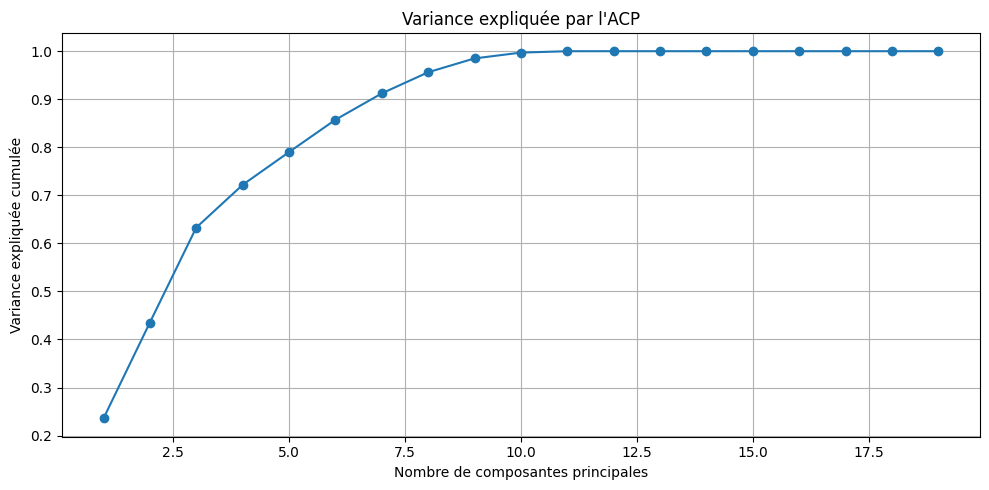

In [5]:
# ACP
pca = PCA()
X_pca = pca.fit_transform(X_scaled)

# Variance expliquée
explained_variance = pca.explained_variance_ratio_
cumulative_variance = explained_variance.cumsum()

# Visualisation de la variance expliquée cumulée
plt.figure(figsize=(10, 5))
plt.plot(range(1, len(cumulative_variance) + 1), cumulative_variance, marker='o')
plt.xlabel("Nombre de composantes principales")
plt.ylabel("Variance expliquée cumulée")
plt.title("Variance expliquée par l'ACP")
plt.grid(True)
plt.tight_layout()
plt.show()

🎯 Justification du choix du nombre de composantes (PCA)

L’ACP (Analyse en Composantes Principales) nous permet de réduire la dimensionnalité du jeu de données tout en conservant l’essentiel de l'information.  
Le graphique ci-dessus montre que :

- Les 7 premières composantes principales expliquent plus de 90 % de la variance totale.
- À partir de la 8e composante, les gains supplémentaires sont négligeables (courbe qui sature).

🔎 **Nous retenons donc 7 dimensions**, ce qui permet :
- Une réduction efficace de la complexité du modèle ;
- Une conservation de la majorité des patterns comportementaux ;
- Une accélération du clustering tout en maintenant sa fiabilité.

In [6]:
# Garder les 7 premières composantes
X_pca_7 = X_pca[:, :7]
df_pca_7 = pd.DataFrame(X_pca_7, columns=[f'PC{i+1}' for i in range(7)], index=X_numeric.index)

In [7]:
# Colonnes exclues de l'ACP (non numériques)
excluded_cols = [col for col in df.columns if col not in numeric_cols and col != 'user_id']
categorical_cols = df.loc[X_numeric.index, excluded_cols].copy()  # ⬅ important : alignement

# Encodage simple des colonnes catégorielles
from sklearn.preprocessing import LabelEncoder
for col in categorical_cols.select_dtypes(include=['object', 'bool']).columns:
    categorical_cols[col] = LabelEncoder().fit_transform(categorical_cols[col].astype(str))

# Fusion PCA + variables catégorielles
dataset_init_final = pd.concat([df_pca_7, categorical_cols], axis=1)

# Réintégration de l'identifiant
dataset_init_final['user_id'] = df.loc[X_numeric.index, 'user_id'].values

# Vérification
print("✔️ Dimensions du dataset final :", dataset_init_final.shape)
dataset_init_final.head()


✔️ Dimensions du dataset final : (1843439, 8)


PC1       PC2       PC3       PC4       PC5       PC6       PC7  \
0 -0.309088 -0.039450  0.153501  0.009085  0.039475 -0.004226 -0.582374   
1  0.370067  0.082297  0.671939 -0.113872 -0.595120 -0.152421 -0.135821   
2 -0.393139 -0.088035 -0.071660 -0.067336 -0.552567 -0.127585 -0.134304   
3  1.071359 -0.245543 -0.359327  0.054884  1.163947  0.283463  1.786269   
4 -0.468090 -0.081782 -0.049821 -0.061130 -0.527388 -0.121891 -0.132579   

      user_id  
0    39084553  
1  4872447178  
2    35628099  
3   351196385  
4  1874916350

## 4. Clustering : choix de k et modélisation

 Évaluation du Silhouette Score pour différentes valeurs de k :
  ➤ k = 2, Silhouette Score = 0.9928
  ➤ k = 3, Silhouette Score = 0.9391
  ➤ k = 4, Silhouette Score = 0.6500
  ➤ k = 5, Silhouette Score = 0.6450
  ➤ k = 6, Silhouette Score = 0.6320
  ➤ k = 7, Silhouette Score = 0.6331
  ➤ k = 8, Silhouette Score = 0.6567
  ➤ k = 9, Silhouette Score = 0.5587
  ➤ k = 10, Silhouette Score = 0.5578


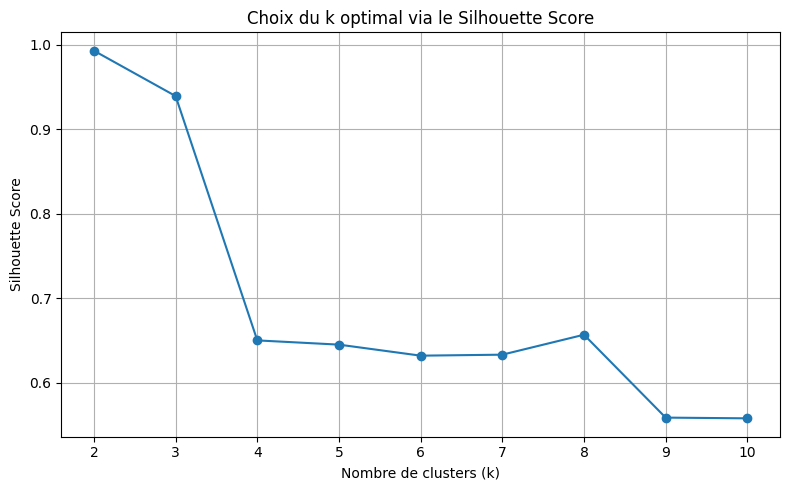


 Meilleur nombre de clusters selon Silhouette Score : k = 2


In [8]:
# Recherche du k optimal via le Silhouette Score
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
from sklearn.utils import resample

# Utilisation des 7 premières composantes déjà calculées dans X_pca_7
X_sample = resample(X_pca_7, n_samples=8000, random_state=42)

silhouette_scores = []
K_range = range(2, 11)

print(" Évaluation du Silhouette Score pour différentes valeurs de k :")
for k in K_range:
    kmeans = KMeans(n_clusters=k, random_state=42)
    labels = kmeans.fit_predict(X_sample)
    score = silhouette_score(X_sample, labels)
    silhouette_scores.append(score)
    print(f"  ➤ k = {k}, Silhouette Score = {score:.4f}")

# Visualisation du Silhouette Score
plt.figure(figsize=(8, 5))
plt.plot(K_range, silhouette_scores, marker='o')
plt.xlabel("Nombre de clusters (k)")
plt.ylabel("Silhouette Score")
plt.title("Choix du k optimal via le Silhouette Score")
plt.grid(True)
plt.tight_layout()
plt.show()

# Sélection automatique du meilleur k
k_optimal = K_range[np.argmax(silhouette_scores)]
print(f"\n Meilleur nombre de clusters selon Silhouette Score : k = {k_optimal}")


In [9]:
from sklearn.cluster import MiniBatchKMeans

# Clustering final sur 50 000 points à partir des 7 composantes principales
X_sample_100k = resample(X_pca_7, n_samples=100000, random_state=42)

kmeans_final = MiniBatchKMeans(n_clusters=k_optimal, random_state=42, batch_size=5000)
clusters = kmeans_final.fit_predict(X_sample_100k)


## 5. Visualisation et analyse des résultats

In [10]:
import pandas as pd
import plotly.express as px
import plotly.io as pio
import umap

pio.renderers.default = 'notebook'

reducer = umap.UMAP(
    n_neighbors=10,
    min_dist=0.3,
    n_components=2,
    random_state=42,
    low_memory=True,
    n_epochs=100,          
    verbose=True
)
X_umap = reducer.fit_transform(X_sample_100k)

df_umap = pd.DataFrame(X_umap, columns=["UMAP1", "UMAP2"])
df_umap["cluster"] = clusters

color_map = {0: '0', 1: '1'}
df_umap["cluster"] = df_umap["cluster"].astype(int)  


fig = px.scatter(
    df_umap,
    x="UMAP1",
    y="UMAP2",
    color=df_umap["cluster"].map(color_map),  
    category_orders={"cluster": [0, 1]},      
    labels={"color": "Cluster"},
    title="UMAP visualisation 2D",
    opacity=0.6,
    width=900,
    height=600
)

fig.update_layout(legend_title_text='Cluster')  
fig.show()

c:\Users\14590\AppData\Local\Programs\Python\Python313\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
c:\Users\14590\AppData\Local\Programs\Python\Python313\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

c:\Users\14590\AppData\Local\Programs\Python\Python313\Lib\site-packages\umap\umap_.py:1952: UserWarning:

n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.



UMAP(min_dist=0.3, n_epochs=100, n_jobs=1, n_neighbors=10, random_state=42, verbose=True)
Sat Jun 14 22:00:00 2025 Construct fuzzy simplicial set
Sat Jun 14 22:00:00 2025 Finding Nearest Neighbors
Sat Jun 14 22:00:00 2025 Building RP forest with 21 trees
Sat Jun 14 22:00:13 2025 NN descent for 17 iterations
	 1  /  17
	 2  /  17
	 3  /  17
	Stopping threshold met -- exiting after 3 iterations
Sat Jun 14 22:00:48 2025 Finished Nearest Neighbor Search
Sat Jun 14 22:00:53 2025 Construct embedding


c:\Users\14590\AppData\Local\Programs\Python\Python313\Lib\site-packages\umap\spectral.py:548: UserWarning:

Spectral initialisation failed! The eigenvector solver
failed. This is likely due to too small an eigengap. Consider
adding some noise or jitter to your data.

Falling back to random initialisation!

Epochs completed:   1%|            1/100 [00:01]

	completed  0  /  100 epochs


Epochs completed:  11%| █          11/100 [00:03]

	completed  10  /  100 epochs


Epochs completed:  21%| ██         21/100 [00:06]

	completed  20  /  100 epochs


Epochs completed:  32%| ███▏       32/100 [00:09]

	completed  30  /  100 epochs


Epochs completed:  41%| ████       41/100 [00:12]

	completed  40  /  100 epochs


Epochs completed:  51%| █████      51/100 [00:15]

	completed  50  /  100 epochs


Epochs completed:  62%| ██████▏    62/100 [00:18]

	completed  60  /  100 epochs


Epochs completed:  71%| ███████    71/100 [00:20]

	completed  70  /  100 epochs


Epochs completed:  81%| ████████   81/100 [00:23]

	completed  80  /  100 epochs


Epochs completed:  93%| █████████▎ 93/100 [00:27]

	completed  90  /  100 epochs


Epochs completed: 100%| ██████████ 100/100 [00:29]


Sat Jun 14 22:01:49 2025 Finished embedding


In [11]:
# from IPython.display import Image, display

# # 🔍 Résultat final du clustering KMeans (projection Umap 2D)
# # La figure interactive Plotly étant trop lourde pour un affichage direct sur GitHub,
# # nous enregistrons la visualisation au format PNG pour une consultation plus simple.

# display(Image(filename="../dataset/Kmeans_visu.png"))

## 6.Analyse des clusters : distribution et interprétation

In [12]:
from collections import Counter

counts = Counter(clusters)
total = sum(counts.values())

for label, count in counts.items():
    print(f"Cluster {label}: {count} utilisateurs ({count / total:.2%})")


Cluster 0: 22807 utilisateurs (22.81%)
Cluster 1: 77193 utilisateurs (77.19%)


**Analyse des clusters : distribution et interprétation**

L’algorithme de **KMeans** a segmenté les profils en **deux groupes distincts**.

| ID du cluster | Nombre d'utilisateurs | Pourcentage | Interprétation |
|---------------|------------------------|--------------|----------------|
| **0**         | 22 807                 | 22,81 %      |  |
| **1**         | 77 193                 | 77,19 %      |  |

Les clusters semblent représenter deux grands types de comportements : un groupe standard et un groupe plus atypique (potentiellement suspect). La visualisation via l’Umap confirme cette séparation nette.                 **Limites** : L’approche reste non supervisée, donc sans garantie que les clusters correspondent aux "bons" ou "mauvais" profils étiquetés dans la réalité.          
📌 Une exploration détaillée des variables clés (tweets_per_day, visibility, aggressiveness...) permettra de valider cette hypothèse.
